In [1]:
import pandas as pd

df = pd.read_parquet('../data/training_data/traindf_100km.pq')
col_map = dict(zip(df.columns, range(len(df.columns))))
df.columns

Index(['fco2rec_uatm', 'sst_cci', 'sss_cci', 'pppp_hpa', 'woa_sss',
       'ncep_slp_hpa', 'dist_to_land_km', 'chl_globcolour', 'temp_soda',
       'salt_soda', 'mld_dens_soda', 'ssh_adt', 'ssh_sla', 'ice_cci'],
      dtype='object')

In [2]:
from dataset_create.ucruise import filter_nans
num_bins = df.index.get_level_values('bin').unique().shape[0]
num_segments = df.index.get_level_values('segment').unique().shape[0]
ds = df.values.reshape(len(df.columns), num_segments, num_bins)
y = df.fco2rec_uatm.values.reshape(num_segments, num_bins)
ds = ds[:, :, :-1]
y = y[:, :-1]
X, y = filter_nans(ds, y, ['sst_cci', 'sss_cci'], col_map)
X.shape, y.shape


Number of samples after filtering:  98664


((2, 98664, 64), (98664, 64))

[274.335   275.03    275.36557 275.33    275.60797 275.71          nan
       nan 277.      277.301   278.1     278.21    278.19998 278.31
 278.3057  278.4373  278.16    278.50998 278.61    279.327   280.322
 280.6109  280.98727 281.22397 281.92334 282.67502 283.24    284.46634
 284.305   286.065   287.2533  286.09274       nan 288.22    288.88998
       nan       nan       nan 289.99    289.11777 287.83    288.28
 287.3675  287.24    286.22598 284.97    285.20197 284.17996 283.472
 282.62    281.3533  280.37    279.91333 280.072   279.71182 278.185
 277.72998 277.62          nan       nan       nan 275.34    274.97
 275.03   ]


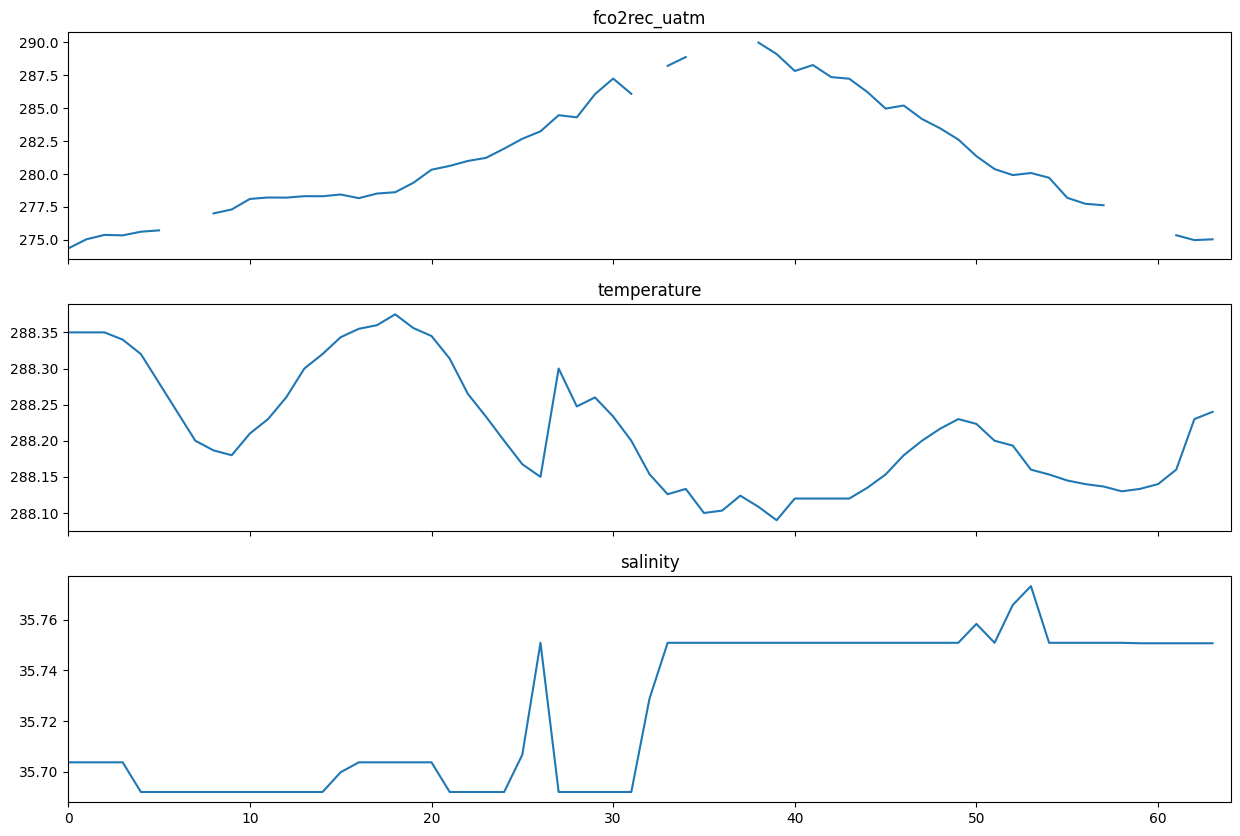

In [3]:
from dataset_create.ucruise import plot_segment
import matplotlib.pyplot as plt

plot_segment(X, y, ['fco2rec_uatm', 'temperature', 'salinity'], 10000)
# print(X[0, 0, :])

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
# import wandb
from tqdm import tqdm
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMScheduler, UNet1DModel
from fco2models.utraining import train_diffusion
from torch.utils.data import TensorDataset

print(X.shape, y[np.newaxis].shape)
assert np.isnan(X).sum() == 0
n_samples = X.shape[1]
n_dims = X.shape[2]
# print(y[:16])
ds = np.zeros((n_samples, 3, n_dims))
ds[:, 0, :] = y
ds[:, 1, :] = X[0]
ds[:, 2, :] = X[1]
# normalize
ds[:, 0, :] = (ds[:, 0, :] - np.nanmean(ds[:, 0, :])) / np.nanstd(ds[:, 0, :])
ds[:, 1, :] = (ds[:, 1, :] - ds[:, 1, :].mean()) / ds[:, 1, :].std()
ds[:, 2, :] = (ds[:, 2, :] - ds[:, 2, :].mean()) / ds[:, 2, :].std()
# split into training and validation
train_ds = ds[:int(0.9 * n_samples)]
val_ds = ds[int(0.9 * n_samples):]
train_dataset = TensorDataset(torch.from_numpy(train_ds))

(2, 98664, 64) (1, 98664, 64)


In [30]:
timestep_dim = 16
model = UNet1DModel(sample_size=64, in_channels= 4 + timestep_dim, out_channels=1)
batch_size = 128
num_epochs = 25
lr = 1e-4
timesteps = 1000
model, noise_scheduler = train_diffusion(model, train_dataset, batch_size=batch_size, num_epochs=num_epochs, lr=lr, timesteps=timesteps, num_workers=2)

Epoch 1/25: 100%|██████████| 694/694 [01:18<00:00,  8.89it/s, loss=0.424]


Epoch 1 Loss: 0.657266


Epoch 2/25: 100%|██████████| 694/694 [01:26<00:00,  8.02it/s, loss=0.528]


Epoch 2 Loss: 0.439675


Epoch 3/25: 100%|██████████| 694/694 [01:27<00:00,  7.95it/s, loss=0.502]


Epoch 3 Loss: 0.414878


Epoch 4/25: 100%|██████████| 694/694 [01:18<00:00,  8.80it/s, loss=0.452]


Epoch 4 Loss: 0.404428


Epoch 5/25: 100%|██████████| 694/694 [01:19<00:00,  8.72it/s, loss=0.451]


Epoch 5 Loss: 0.391579


Epoch 6/25: 100%|██████████| 694/694 [01:18<00:00,  8.86it/s, loss=0.348]


Epoch 6 Loss: 0.374321


Epoch 7/25: 100%|██████████| 694/694 [01:20<00:00,  8.64it/s, loss=0.244]


Epoch 7 Loss: 0.367402


Epoch 8/25: 100%|██████████| 694/694 [01:17<00:00,  8.94it/s, loss=0.39] 


Epoch 8 Loss: 0.353888


Epoch 9/25: 100%|██████████| 694/694 [01:21<00:00,  8.55it/s, loss=0.273]


Epoch 9 Loss: 0.341016


Epoch 10/25: 100%|██████████| 694/694 [01:24<00:00,  8.22it/s, loss=0.376]


Epoch 10 Loss: 0.322966


Epoch 11/25: 100%|██████████| 694/694 [01:16<00:00,  9.07it/s, loss=0.344]


Epoch 11 Loss: 0.319894


Epoch 12/25: 100%|██████████| 694/694 [01:15<00:00,  9.17it/s, loss=0.327]


Epoch 12 Loss: 0.314504


Epoch 13/25: 100%|██████████| 694/694 [01:18<00:00,  8.81it/s, loss=0.197]


Epoch 13 Loss: 0.313748


Epoch 14/25: 100%|██████████| 694/694 [01:19<00:00,  8.76it/s, loss=0.27] 


Epoch 14 Loss: 0.308432


Epoch 15/25: 100%|██████████| 694/694 [01:17<00:00,  8.92it/s, loss=0.275]


Epoch 15 Loss: 0.308836


Epoch 16/25: 100%|██████████| 694/694 [01:21<00:00,  8.50it/s, loss=0.186]


Epoch 16 Loss: 0.307040


Epoch 17/25: 100%|██████████| 694/694 [01:42<00:00,  6.76it/s, loss=0.375]


Epoch 17 Loss: 0.304269


Epoch 18/25: 100%|██████████| 694/694 [02:09<00:00,  5.35it/s, loss=0.253]


Epoch 18 Loss: 0.305910


Epoch 19/25: 100%|██████████| 694/694 [02:08<00:00,  5.41it/s, loss=0.428]


Epoch 19 Loss: 0.301059


Epoch 20/25: 100%|██████████| 694/694 [01:41<00:00,  6.82it/s, loss=0.339]


Epoch 20 Loss: 0.296286


Epoch 21/25: 100%|██████████| 694/694 [02:06<00:00,  5.47it/s, loss=0.292]


Epoch 21 Loss: 0.304307


Epoch 22/25: 100%|██████████| 694/694 [02:06<00:00,  5.51it/s, loss=0.341]


Epoch 22 Loss: 0.298955


Epoch 23/25: 100%|██████████| 694/694 [01:55<00:00,  6.03it/s, loss=0.259]


Epoch 23 Loss: 0.299272


Epoch 24/25: 100%|██████████| 694/694 [01:44<00:00,  6.65it/s, loss=0.364]


Epoch 24 Loss: 0.297752


Epoch 25/25: 100%|██████████| 694/694 [02:16<00:00,  5.10it/s, loss=0.272]

Epoch 25 Loss: 0.303066


In [31]:
# save the model
torch.save(model.state_dict(), '../models/first/model_1d.pt')
noise_scheduler.save_config('../models/first')
# save also model hyperparameters
import json
with open('../models/first/1d_model_params.json', 'w') as f:
    json.dump({'batch_size': batch_size, 
               'num_epochs': num_epochs, 
               'lr': lr,
               'timesteps': 1000
               }, f)
# wandb.finish()
# print('done')

In [32]:
# load the model
model = UNet1DModel(sample_size=64, in_channels=4 + timestep_dim, out_channels=1)
model.load_state_dict(torch.load('../models/first/model_1d.pt'))
model.eval()
# random model
random_model = UNet1DModel(sample_size=64, in_channels=4 + timestep_dim, out_channels=1)
random_model.eval()
# load the scheduler
noise_scheduler_config = DDPMScheduler.load_config('../models/first/scheduler_config.json', local_files_only=True)
noise_scheduler = DDPMScheduler(**noise_scheduler_config)
# load also model hyperparameters
import json
with open('../models/first/1d_model_params.json', 'r') as f:
    model_params = json.load(f)

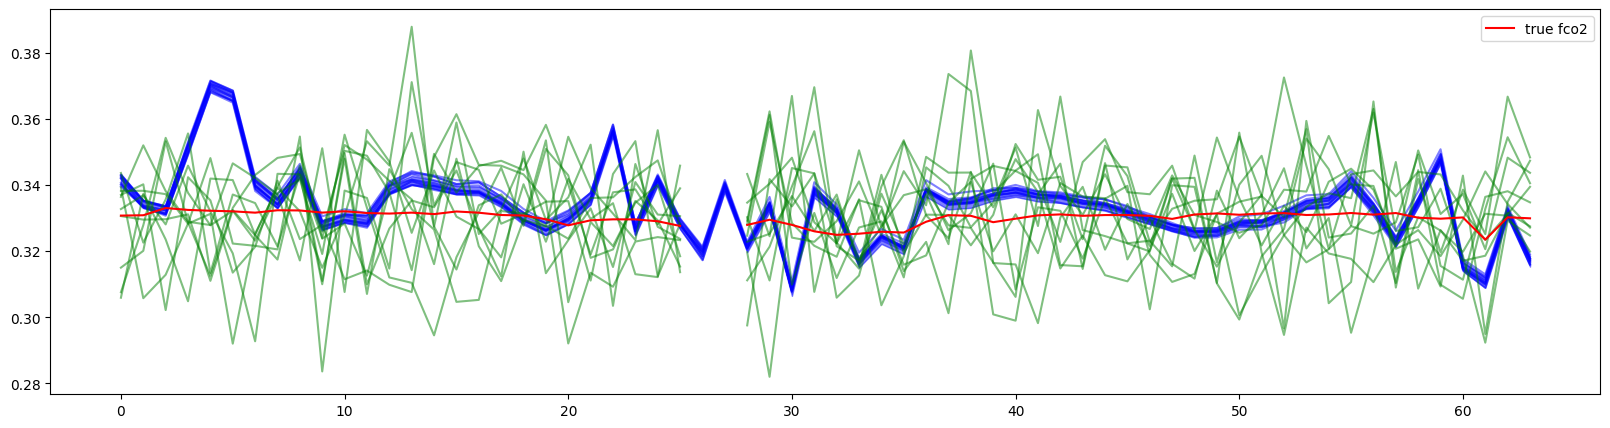

In [38]:
ix = 11103
sample = torch.from_numpy(train_ds[ix, 0:1, :]).float()
nan_sample = torch.where(torch.isnan(sample), torch.zeros_like(sample), sample)
context = torch.from_numpy(train_ds[ix, 1:, :]).float()
# add nan mask to the context
nan_mask = ~torch.isnan(sample)
context = torch.cat([context, nan_mask.float()], dim=0)
timesteps = torch.tensor([1])
# sample 100 times and plot the distribution of reconstructed fco2
reconstructed_fco2s = []
random = []
noisy_samples = []
for _ in range(100):
    noise = torch.randn_like(nan_sample)
    noisy_sample = noise_scheduler.add_noise(nan_sample, noise, timesteps)
    input = torch.cat([noisy_sample, context], dim=0).unsqueeze(0)
    with torch.no_grad():
        output = model(sample=input, timestep=timesteps)
        random_output = random_model(sample=input, timestep=timesteps)

    reconstructed_fco2s.append(output[0].numpy().flatten())
    nan_noisy_sample = torch.where(~nan_mask, torch.nan, noisy_sample)
    noisy_samples.append(nan_noisy_sample.numpy().flatten())
    random.append(random_output[0].numpy().flatten())
reconstructed_fco2s = np.array(reconstructed_fco2s)
random = np.array(random)
noisy_samples = np.array(noisy_samples)
plt.figure(figsize=(20, 5))
plt.plot(reconstructed_fco2s.T[:,:10], color='blue', alpha=0.5)
# plot devations from the mean
plt.fill_between(np.arange(0, num_bins - 1), reconstructed_fco2s.mean(axis=0) - reconstructed_fco2s.std(axis=0),
                 reconstructed_fco2s.mean(axis=0) + reconstructed_fco2s.std(axis=0), color='blue', alpha=0.5)
plt.plot(noisy_samples.T[:,:10], color='green', alpha=0.5)
# plt.plot(random.T, color='green', alpha=0.05)
# plt.plot(reconstructed_fco2s.mean(axis=0), label='reconstructed fco2')
# plt.plot(random.mean(axis=0), label='random diffusion')
plt.plot(sample.flatten(), label='true fco2', color='red')
plt.legend()
plt.show()
# print(reconstructed_fco2s